In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# label encoding the data 
from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn import metrics


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS
  
import seaborn as sns
sns.set(rc={'figure.figsize':(6,6)}) 
%matplotlib inline

from IPython.display import Image

import warnings
warnings.simplefilter("ignore")



#For the target i used: 'score_text'
#Scores 1 to 4 were labeled by COMPAS as “Low”; 5 to 7 were labeled “Medium”; and 8 to 10 were labeled “High.”
#instead of predicting decile score should I try predicting the score range as in "high", "medium", "low" will that give me a better accuracy
#do I need to do any standardization


import seaborn as sns

#This makes all of our graphs show up in our notebook when they're made
%matplotlib inline

In [2]:
#loading in DATA
df = pd.read_csv('./cox-violent-parsed_filt.csv')
df.head()
df.columns
df.dtypes

#off the bat: what columns I am going to drop 

#id -->won't matter when training data
#name --> same as above
#first --> same as above
#last --> same as above
#dob --> same as above
#age --> age category is a better independent variable to look at

#after a look at the data: what columns I am going to drop
#priors_count.1--> same column as priors_count
#decile_score.1 --> same as "decile_score"
#the decile score correlates to the type_of_assessment, so the decile score is the score a person gets for risk of recidivism
#the v_decile_score correlate to the v_type_of_assessment, so the v_decile_score is the score a person get for risk of violence
#we can delete v_type_of assessment and type_of_assessment because of this 



#removing duplicates before editing any data 
print(df.shape)

# Rows containing duplicate data
duplicate_rows_df = df[df.duplicated() == True]

print(duplicate_rows_df.shape)
duplicate_rows_df

df = df.drop_duplicates(keep='first')


print(df.shape)



(18316, 40)
(2803, 40)
(15513, 40)


In [3]:
df.head()
df.columns
df = df.drop(['id','name',"first","last","dob","age","decile_score.1", 'event',
             'priors_count.1'], axis=1)

In [4]:
df[['sex', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',]].head(25)
#keep all of these
#score_text is going to be our target variable -- >
#tells us the likelihood of recidivism for each person based on the independent variables chosen
df = df.drop(['decile_score'], axis=1)

df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,...,is_violent_recid,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text
0,Male,Greater than 45,Other,0,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,...,0,NaN,NaN,NaN,Risk of Recidivism,Low,14/08/2013,Risk of Violence,1,Low
1,Male,Greater than 45,Other,0,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,...,0,NaN,NaN,NaN,Risk of Recidivism,Low,14/08/2013,Risk of Violence,1,Low
2,Male,25 - 45,Caucasian,0,0,0,0,NaN,NaN,NaN,...,0,NaN,NaN,NaN,Risk of Recidivism,Medium,31/12/2014,Risk of Violence,2,Low
3,Male,25 - 45,African-American,0,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,...,1,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,Low,27/01/2013,Risk of Violence,1,Low
4,Male,Less than 25,African-American,0,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,...,0,NaN,NaN,NaN,Risk of Recidivism,Low,14/04/2013,Risk of Violence,3,Low


In [5]:
df[['days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc']].head(25)

#remove 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out','c_days_from_compas', and 'c_charge_desc'
#keep charge degree 

df = df.drop(['days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_days_from_compas','c_charge_desc'], axis=1)
df.head()


,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,r_charge_degree,...,is_violent_recid,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text
0,Male,Greater than 45,Other,0,0,0,0,(F3),0,NaN,...,0,NaN,NaN,NaN,Risk of Recidivism,Low,14/08/2013,Risk of Violence,1,Low
1,Male,Greater than 45,Other,0,0,0,0,(F3),0,NaN,...,0,NaN,NaN,NaN,Risk of Recidivism,Low,14/08/2013,Risk of Violence,1,Low
2,Male,25 - 45,Caucasian,0,0,0,0,NaN,-1,NaN,...,0,NaN,NaN,NaN,Risk of Recidivism,Medium,31/12/2014,Risk of Violence,2,Low
3,Male,25 - 45,African-American,0,0,0,0,(F3),1,(F3),...,1,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,Low,27/01/2013,Risk of Violence,1,Low
4,Male,Less than 25,African-American,0,0,1,4,(F3),1,(M1),...,0,NaN,NaN,NaN,Risk of Recidivism,Low,14/04/2013,Risk of Violence,3,Low


In [6]:
df[['is_recid',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text']].head(25)


#remove , 'r_days_from_arrest', 'r_offense_date','r_charge_desc', 'r_jail_in', 'violent_recid'
#'vr_offense_date', 'vr_charge_desc', 'screening_date', 'v_score_text'
#encode v_type_of_assessment


df = df.drop(['v_type_of_assessment','type_of_assessment', 'r_days_from_arrest', 'r_offense_date','r_charge_desc', 'r_jail_in', 'violent_recid','vr_offense_date', 'vr_charge_desc', 'screening_date', 'v_score_text'], axis=1)
df.head(25)


,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,r_charge_degree,is_violent_recid,vr_charge_degree,score_text,v_decile_score
0,Male,Greater than 45,Other,0,0,0,0,(F3),0,NaN,0,NaN,Low,1
1,Male,Greater than 45,Other,0,0,0,0,(F3),0,NaN,0,NaN,Low,1
2,Male,25 - 45,Caucasian,0,0,0,0,NaN,-1,NaN,0,NaN,Medium,2
3,Male,25 - 45,African-American,0,0,0,0,(F3),1,(F3),1,(F3),Low,1
4,Male,Less than 25,African-American,0,0,1,4,(F3),1,(M1),0,NaN,Low,3
5,Male,Less than 25,African-American,0,0,1,4,(F3),1,(M1),0,NaN,Low,3
6,Male,Less than 25,African-American,0,0,1,4,(F3),1,(M1),0,NaN,Low,3
7,Male,Less than 25,African-American,0,0,1,4,(F3),1,(M1),0,NaN,Low,3
8,Male,Less than 25,African-American,0,0,1,4,(F3),1,(M1),0,NaN,Low,3
9,Male,Less than 25,African-American,0,1,0,1,(F3),0,NaN,0,NaN,High,6


In [7]:
#conlusions
    #both zero and negative one denote that there is no recidivism charge --> can replace
    
df['is_recid'] = df['is_recid'].replace({
    -1:0
})

df.is_recid.unique()
df.head(25)

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,r_charge_degree,is_violent_recid,vr_charge_degree,score_text,v_decile_score
0,Male,Greater than 45,Other,0,0,0,0,(F3),0,NaN,0,NaN,Low,1
1,Male,Greater than 45,Other,0,0,0,0,(F3),0,NaN,0,NaN,Low,1
2,Male,25 - 45,Caucasian,0,0,0,0,NaN,0,NaN,0,NaN,Medium,2
3,Male,25 - 45,African-American,0,0,0,0,(F3),1,(F3),1,(F3),Low,1
4,Male,Less than 25,African-American,0,0,1,4,(F3),1,(M1),0,NaN,Low,3
5,Male,Less than 25,African-American,0,0,1,4,(F3),1,(M1),0,NaN,Low,3
6,Male,Less than 25,African-American,0,0,1,4,(F3),1,(M1),0,NaN,Low,3
7,Male,Less than 25,African-American,0,0,1,4,(F3),1,(M1),0,NaN,Low,3
8,Male,Less than 25,African-American,0,0,1,4,(F3),1,(M1),0,NaN,Low,3
9,Male,Less than 25,African-American,0,1,0,1,(F3),0,NaN,0,NaN,High,6


In [8]:
#df_check = df[['decile_score','decile_score.1']]
#df_check
#ct = 0
#for i in range(0,df_check.shape[0]):
    #if df_check.at[i, 'decile_score'] == df_check.at[i, 'decile_score.1']:
        #ct+=1
#print(ct)

#decile_score and #decile_score.1 are the same



#df_check = df[['priors_count','priors_count.1']]
#df_check
#ct = 0
#for i in range(0,df_check.shape[0]):
    #if df_check.at[i, 'priors_count'] == df_check.at[i, 'priors_count.1']:
        #ct+=1
#print(ct)

#priors_count and #priors_count.1 are the same


df.columns

#original columns
'sex', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
'juv_misd_count', 'juv_other_count', 'priors_count',
'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid',
'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
'type_of_assessment', 'score_text', 'screening_date',
'v_type_of_assessment', 'v_decile_score', 'v_score_text'

#new columns
'sex', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree',
'is_recid', 'r_charge_degree', 'is_violent_recid', 'vr_charge_degree',
'v_decile_score'

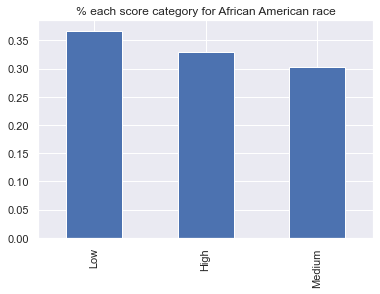

In [9]:
df[df["race"]=="African-American"].score_text.value_counts(normalize= True).plot(kind = "bar", title = "% each score category for African American race")


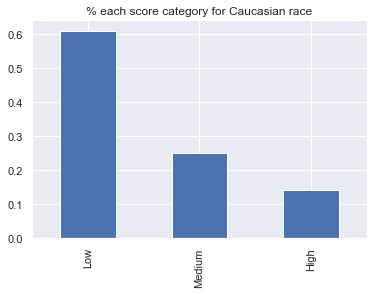

In [10]:
df[df["race"]=="Caucasian"].score_text.value_counts(normalize= True).plot(kind = "bar", title = "% each score category for Caucasian race")

In [11]:
df.dtypes
#encode sex, age_cat, race, c_charge_degree, r_charge_degree, vr_charge_degree
#must fill null cells first

df.loc[df['race'].str.contains('Native American'),
             'race'] = 'Other'

785


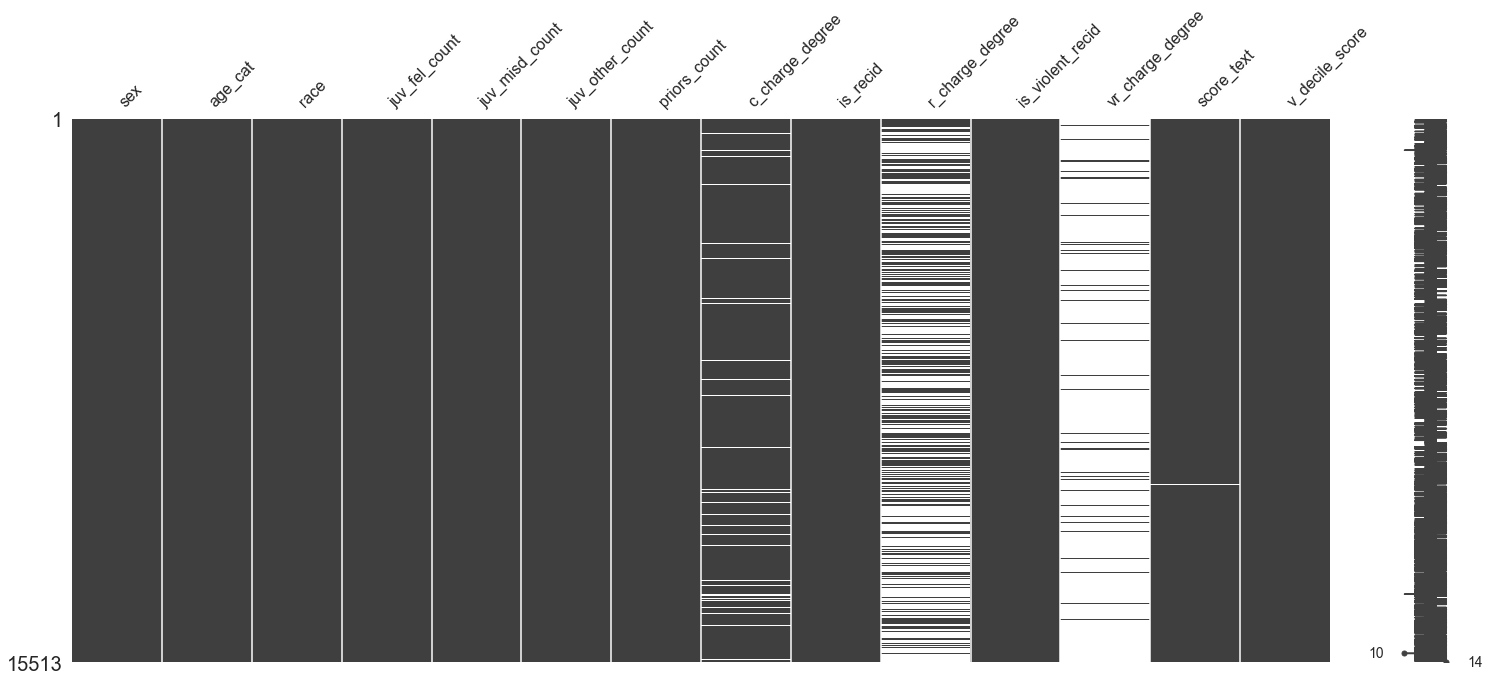

In [12]:
import missingno as msno

msno.matrix(df);

print(df.c_charge_degree.isnull().sum())

In [13]:
#dropping r_charge_degree and vr_charge_degree
df = df.drop(['r_charge_degree','vr_charge_degree'], axis=1)

mode = df.c_charge_degree.mode()
df['c_charge_degree']= df['c_charge_degree'].fillna(mode[0])

#use mode to fill missing values for c_charge_degree ... missing values imputation techniques

In [14]:
df.head(25)

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,is_violent_recid,score_text,v_decile_score
0,Male,Greater than 45,Other,0,0,0,0,(F3),0,0,Low,1
1,Male,Greater than 45,Other,0,0,0,0,(F3),0,0,Low,1
2,Male,25 - 45,Caucasian,0,0,0,0,(F3),0,0,Medium,2
3,Male,25 - 45,African-American,0,0,0,0,(F3),1,1,Low,1
4,Male,Less than 25,African-American,0,0,1,4,(F3),1,0,Low,3
5,Male,Less than 25,African-American,0,0,1,4,(F3),1,0,Low,3
6,Male,Less than 25,African-American,0,0,1,4,(F3),1,0,Low,3
7,Male,Less than 25,African-American,0,0,1,4,(F3),1,0,Low,3
8,Male,Less than 25,African-American,0,0,1,4,(F3),1,0,Low,3
9,Male,Less than 25,African-American,0,1,0,1,(F3),0,0,High,6


In [15]:
print(df.c_charge_degree.unique())
print(df.c_charge_degree.isnull().sum())

['(F3)' '(F7)' '(M1)' '(F2)' '(F1)' '(M2)' '(MO3)' '(X)' '(CT)' '(NI0)'
 '(F5)' '(TCX)' '(F6)' '(CO3)']
0


array(['Low', 'Medium', 'High'], dtype=object)

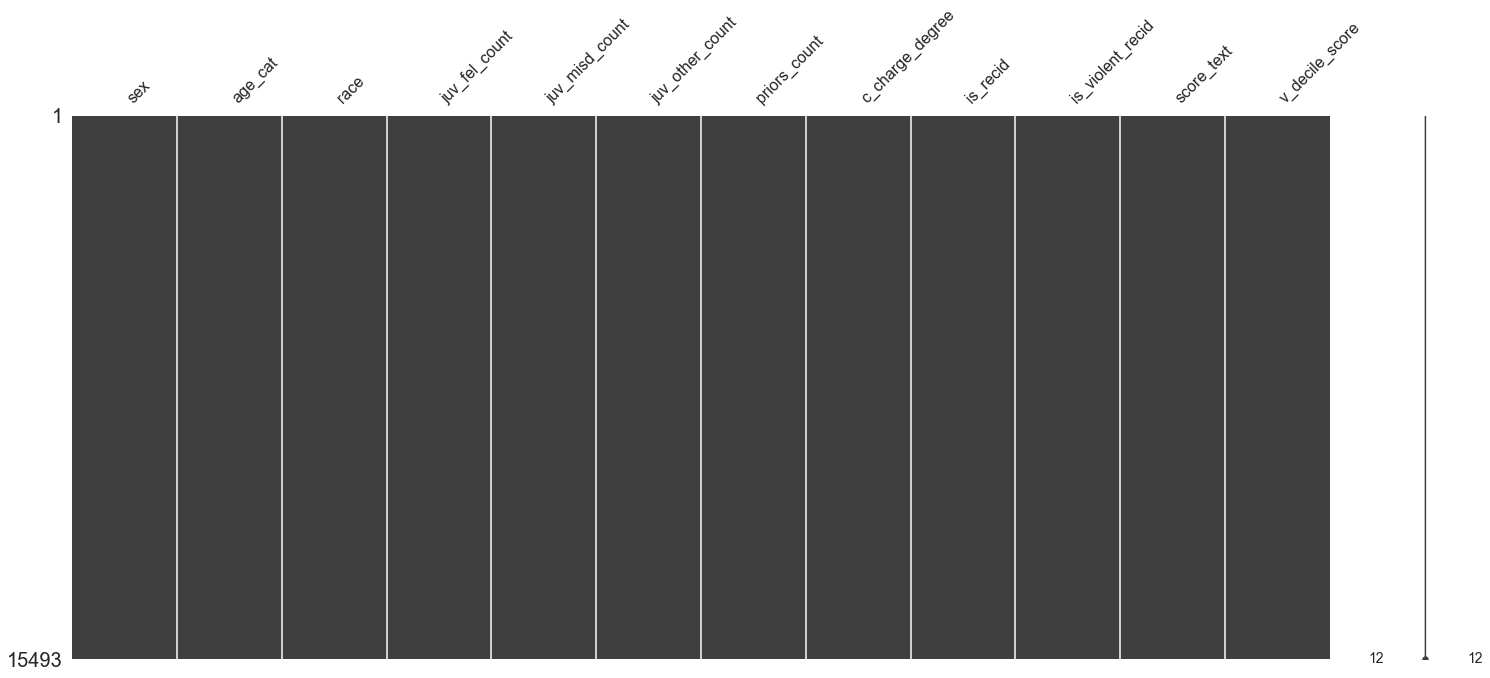

In [16]:
df = df[~df.score_text.isna()]
msno.matrix(df);
df.score_text.unique()

In [17]:
df.describe()
df.columns
df.age_cat.unique()

array(['Greater than 45', '25 - 45', 'Less than 25'], dtype=object)

In [18]:
#Classification ML

In [19]:
# set up our data for sklearn
target_variable = "score_text" 
independent_variables = df.drop(target_variable, axis=1) # feature variables
target_variable = df[target_variable] # target variable


In [20]:
#splitting up independent variables into numerical and categorical
categorical_columns = independent_variables.select_dtypes([object, "category"]).columns
numerical_columns= independent_variables.select_dtypes(np.number).columns

In [21]:
categorical_data = independent_variables[categorical_columns]
numerical_data = independent_variables[numerical_columns]
display(categorical_data)
display(numerical_data)
categorical_data.race.unique()


,sex,age_cat,race,c_charge_degree
0,Male,Greater than 45,Other,(F3)
1,Male,Greater than 45,Other,(F3)
2,Male,25 - 45,Caucasian,(F3)
3,Male,25 - 45,African-American,(F3)
4,Male,Less than 25,African-American,(F3)
...,...,...,...,...
18310,Male,Less than 25,African-American,(F3)
18311,Female,25 - 45,African-American,(M1)
18312,Male,Greater than 45,Other,(F2)
18313,Female,25 - 45,African-American,(M1)


,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,v_decile_score
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,2
3,0,0,0,0,1,1,1
4,0,0,1,4,1,0,3
...,...,...,...,...,...,...,...
18310,0,0,0,0,0,0,5
18311,0,0,0,5,0,0,4
18312,0,0,0,0,0,0,1
18313,0,0,0,3,0,0,2


array(['Other', 'Caucasian', 'African-American', 'Hispanic', 'Asian'],
      dtype=object)

In [22]:
#encoding categorical data
categorical_data_codified = pd.get_dummies(
                                    categorical_data, 
                                    dtype="int64")
categorical_data_codified.head()
categorical_data_codified.columns


Index(['sex_Female', 'sex_Male', 'age_cat_25 - 45', 'age_cat_Greater than 45',
       'age_cat_Less than 25', 'race_African-American', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other',
       'c_charge_degree_(CO3)', 'c_charge_degree_(CT)', 'c_charge_degree_(F1)',
       'c_charge_degree_(F2)', 'c_charge_degree_(F3)', 'c_charge_degree_(F5)',
       'c_charge_degree_(F6)', 'c_charge_degree_(F7)', 'c_charge_degree_(M1)',
       'c_charge_degree_(M2)', 'c_charge_degree_(MO3)',
       'c_charge_degree_(NI0)', 'c_charge_degree_(TCX)',
       'c_charge_degree_(X)'],
      dtype='object')

In [23]:
#combining codified categorical data back with numerical data
independent_codified = pd.concat([
                            numerical_data,
                            categorical_data_codified # reset index so it matches the numerical
                        ], axis=1
)
independent_codified.columns

Index(['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
       'is_recid', 'is_violent_recid', 'v_decile_score', 'sex_Female',
       'sex_Male', 'age_cat_25 - 45', 'age_cat_Greater than 45',
       'age_cat_Less than 25', 'race_African-American', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other',
       'c_charge_degree_(CO3)', 'c_charge_degree_(CT)', 'c_charge_degree_(F1)',
       'c_charge_degree_(F2)', 'c_charge_degree_(F3)', 'c_charge_degree_(F5)',
       'c_charge_degree_(F6)', 'c_charge_degree_(F7)', 'c_charge_degree_(M1)',
       'c_charge_degree_(M2)', 'c_charge_degree_(MO3)',
       'c_charge_degree_(NI0)', 'c_charge_degree_(TCX)',
       'c_charge_degree_(X)'],
      dtype='object')

In [24]:
independent_codified.head(25)

,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,v_decile_score,sex_Female,sex_Male,age_cat_25 - 45,...,c_charge_degree_(F3),c_charge_degree_(F5),c_charge_degree_(F6),c_charge_degree_(F7),c_charge_degree_(M1),c_charge_degree_(M2),c_charge_degree_(MO3),c_charge_degree_(NI0),c_charge_degree_(TCX),c_charge_degree_(X)
0,0,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,1,1,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,1,0,1,1,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,4,1,0,3,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5,0,0,1,4,1,0,3,0,1,0,...,1,0,0,0,0,0,0,0,0,0
6,0,0,1,4,1,0,3,0,1,0,...,1,0,0,0,0,0,0,0,0,0
7,0,0,1,4,1,0,3,0,1,0,...,1,0,0,0,0,0,0,0,0,0
8,0,0,1,4,1,0,3,0,1,0,...,1,0,0,0,0,0,0,0,0,0
9,0,1,0,1,0,0,6,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(independent_codified, 
                                                    target_variable, 
                                                    test_size=0.15,
                                                    random_state=42
                                                   )

In [26]:
# training set
print(X_train.shape)
print(y_train.shape)

#testing set
print(X_test.shape)
print(y_test.shape)


(13169, 31)
(13169,)
(2324, 31)
(2324,)


In [27]:
#cross validating to find the best parameters for each algorithm

In [28]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#make a function that does cross validation for us without having to retype it each time

def evaluate_model(estimator):
    cv_results = cross_validate(estimator,
                    X=X_train,
                    y=y_train,
                    scoring="accuracy",
                          n_jobs=-1, cv=10,
                     return_train_score=True)
    return pd.DataFrame(cv_results).abs().mean().to_dict()

In [30]:
results = {}  #make an empty dictionary to save results (same as a dataframe really in this case)

In [31]:
initial_tree = DecisionTreeClassifier()
results["initial_tree"] =  evaluate_model(initial_tree)

In [32]:
pd.DataFrame.from_dict(results).T

,fit_time,score_time,test_score,train_score
initial_tree,0.078092,0.003357,0.77599,0.894002


In [33]:
#simple tree
simple_tree = DecisionTreeClassifier(max_depth=4)
results["simple_tree"] =  evaluate_model(simple_tree)

In [34]:
pd.DataFrame.from_dict(results).T

,fit_time,score_time,test_score,train_score
initial_tree,0.078092,0.003357,0.775990,0.894002
simple_tree,0.066030,0.003075,0.692613,0.697311


In [35]:
# I am going to tune for max_depth and criterion: 

# 1) Define hyperparamter search space
search_parameters_space = {
    "max_depth": np.arange(2,10),  # range from 2-9
    "criterion": ["gini", "entropy"], # two options for criterion (check hyperparameter options to read more about these)
}

In [36]:
first_grid = GridSearchCV(estimator=DecisionTreeClassifier(), 
                    param_grid=search_parameters_space,
                    scoring="accuracy",
                    n_jobs=-1)

In [37]:
first_grid.fit(X_train, y_train)
first_grid.best_params_

{'criterion': 'gini', 'max_depth': 9}

In [38]:
estimator = DecisionTreeClassifier(max_depth = 9, criterion = "gini")
results["first_grid"] =  evaluate_model(estimator)
pd.DataFrame.from_dict(results).T

,fit_time,score_time,test_score,train_score
initial_tree,0.078092,0.003357,0.775990,0.894002
simple_tree,0.066030,0.003075,0.692613,0.697311
first_grid,0.083350,0.002388,0.727922,0.763342


In [39]:
from scipy.stats import randint as sp_randint
#from scipy.stats import uniform 

# 1) Defines hyperparamter search space
search_parameters_space_random = {"max_depth": [3, None],
              "max_features": sp_randint(1, 9),
              "min_samples_leaf": sp_randint(1, 9),
              "criterion": ["gini","entropy"]}

In [40]:
# 2) search using random search
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(), 
    param_distributions=search_parameters_space_random,
   scoring="accuracy", n_jobs=-1, 
    n_iter=50)

In [41]:
%%time
random_search.fit(X_train, y_train)

Wall time: 1.52 s


RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000218CF9628B0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000218CF999490>},
                   scoring='accuracy')

In [42]:
random_search.best_score_

0.7289083909874697

In [43]:
random_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 6,
 'min_samples_leaf': 2}

In [44]:
estimator = DecisionTreeClassifier(max_depth = None, criterion = "gini", max_features = 6, min_samples_leaf = 1)
results["random_grid"] =  evaluate_model(estimator)
pd.DataFrame.from_dict(results).T

,fit_time,score_time,test_score,train_score
initial_tree,0.078092,0.003357,0.775990,0.894002
simple_tree,0.066030,0.003075,0.692613,0.697311
first_grid,0.083350,0.002388,0.727922,0.763342
random_grid,0.061986,0.007151,0.771890,0.894002


In [45]:
knn_classifier = KNeighborsClassifier() 
knn_classifier.get_params().keys() #checking what the parameters are

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [46]:
results["noparam_knn_classifier"] = evaluate_model(knn_classifier)
pd.DataFrame.from_dict(results).T

,fit_time,score_time,test_score,train_score
initial_tree,0.078092,0.003357,0.775990,0.894002
simple_tree,0.066030,0.003075,0.692613,0.697311
first_grid,0.083350,0.002388,0.727922,0.763342
random_grid,0.061986,0.007151,0.771890,0.894002
noparam_knn_classifier,0.280028,0.425271,0.734149,0.805233


In [47]:
search_parameters_space_random = {"n_neighbors": [1,20],
              "weights": ["uniform","distance"]}

In [48]:
random_search_knn = RandomizedSearchCV(
    estimator=KNeighborsClassifier(), 
    param_distributions=search_parameters_space_random,
   scoring="accuracy", n_jobs=-1, 
    n_iter=50)

In [49]:
random_search_knn.fit(X_train, y_train)

RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'n_neighbors': [1, 20],
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy')

In [50]:
random_search_knn.best_params_

{'weights': 'distance', 'n_neighbors': 20}

In [51]:
knn_classifier_random = KNeighborsClassifier(weights = "distance", n_neighbors = 20)

In [52]:
results["random_knn_classifier"] = evaluate_model(knn_classifier_random)
pd.DataFrame.from_dict(results).T

,fit_time,score_time,test_score,train_score
initial_tree,0.078092,0.003357,0.775990,0.894002
simple_tree,0.066030,0.003075,0.692613,0.697311
first_grid,0.083350,0.002388,0.727922,0.763342
random_grid,0.061986,0.007151,0.771890,0.894002
noparam_knn_classifier,0.280028,0.425271,0.734149,0.805233
random_knn_classifier,0.395885,0.635351,0.785786,0.893605


In [53]:
#Time to pick best model and its parameters and predict
#Time to make insights

initial_tree.fit(X_train, y_train)
initial_tree.feature_importances_

dict(zip(
    independent_variables,
    initial_tree.feature_importances_ *100
))

{'sex': 1.604425137964152,
 'age_cat': 1.5371880509124856,
 'race': 2.924526223713195,
 'juv_fel_count': 20.53168385060085,
 'juv_misd_count': 4.428876029502423,
 'juv_other_count': 2.38453026230309,
 'priors_count': 41.191084994559425,
 'c_charge_degree': 1.402368450191115,
 'is_recid': 1.868754877749779,
 'is_violent_recid': 1.3075805007552657,
 'v_decile_score': 1.6043598652877213}

In [54]:
#I chose KNN

In [55]:
my_model = KNeighborsClassifier(weights = "distance", n_neighbors = 20)
my_model.fit(X=X_train, y=y_train)

KNeighborsClassifier(n_neighbors=20, weights='distance')

In [56]:
predictions = my_model.predict(X_test)
X = X_test.reset_index().copy() # make a copy of indices and data
X["text_score"] = y_test.tolist()
X["prediction"] = predictions
X.head()

,index,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,v_decile_score,sex_Female,sex_Male,...,c_charge_degree_(F6),c_charge_degree_(F7),c_charge_degree_(M1),c_charge_degree_(M2),c_charge_degree_(MO3),c_charge_degree_(NI0),c_charge_degree_(TCX),c_charge_degree_(X),text_score,prediction
0,2064,0,0,0,13,1,0,7,0,1,...,0,0,0,0,0,0,0,0,High,High
1,7794,0,0,0,0,1,0,5,0,1,...,0,0,1,0,0,0,0,0,High,High
2,14785,0,0,2,2,1,0,5,0,1,...,0,0,0,0,0,0,0,0,Medium,Medium
3,3763,0,0,0,14,1,1,3,0,1,...,0,0,1,0,0,0,0,0,Low,Low
4,11622,0,0,0,0,0,0,6,0,1,...,0,0,0,0,0,0,0,0,Medium,Low


In [57]:
#seperating making new DFs for each race
aa = X[X["race_African-American"] == 1]
a = X[X["race_Asian"] == 1]
c = X[X["race_Caucasian"] == 1]
h = X[X["race_Hispanic"] == 1]
o = X[X["race_Other"] == 1]

#checking each race's accuracy
accuracy_aa = metrics.accuracy_score(aa["text_score"], aa["prediction"])
accuracy_a = metrics.accuracy_score(a["text_score"], a["prediction"])
accuracy_c = metrics.accuracy_score(c["text_score"], c["prediction"])
accuracy_h = metrics.accuracy_score(h["text_score"], h["prediction"])
accuracy_o = metrics.accuracy_score(o["text_score"], o["prediction"])
accuracy_total = metrics.accuracy_score(X["text_score"], X["prediction"])


print("The total accuracy for African American defendants is " + str(100 * accuracy_aa))
print("The total accuracy for Asian defendants is " + str(100 * accuracy_a))
print("The total accuracy for Caucasian defendants is " + str(100 * accuracy_c))
print("The total accuracy for Hispanic defendants is " + str(100 * accuracy_h))
print("The total accuracy for 'Other' defendants is " + str(100 * accuracy_o))
print("The total accuracy is " + str(100 * accuracy_total))

#get the shape of other to explain why it is 10% more accurate

The total accuracy for African American defendants is 79.9520766773163
The total accuracy for Asian defendants is 80.0
The total accuracy for Caucasian defendants is 81.79384203480589
The total accuracy for Hispanic defendants is 81.91489361702128
The total accuracy for 'Other' defendants is 92.62295081967213
The total accuracy is 81.36833046471601


In [58]:
mode_predicted_scoreaa = aa["prediction"].mode()[0]
mode_predicted_scorea = a["prediction"].mode()[0]
mode_predicted_scorec = c["prediction"].mode()[0]
mode_predicted_scoreh = h["prediction"].mode()[0]
mode_predicted_scoreo = o["prediction"].mode()[0]
mode_predicted_total = X["prediction"].mode()[0]

print("The mode score given for African American defendants is " + str(mode_predicted_scoreaa))
print("The mode score given for Asians defendants is " + str(mode_predicted_scorea))
print("The mode score given for Caucasian defendants is " + str(mode_predicted_scorec))
print("The mode score given for Hispanic defendants is " + str(mode_predicted_scoreh))
print("The mode score given for 'Other' defendants is " + str(mode_predicted_scoreo))
print("The mode score for all defendants is " + str(mode_predicted_total))


The mode score given for African American defendants is Low
The mode score given for Asians defendants is Low
The mode score given for Caucasian defendants is Low
The mode score given for Hispanic defendants is Low
The mode score given for 'Other' defendants is Low
The mode score for all defendants is Low


In [59]:
men = X[X["sex_Male"] == 1]
women = X[X["sex_Female"] == 1]

men_accuracy = metrics.accuracy_score(men["text_score"], men["prediction"])
women_accuracy = metrics.accuracy_score(women["text_score"], women["prediction"])

print("the total accuracy for all men is " + str(100*men_accuracy))
print("the total accuracy for all women is " + str(100*women_accuracy))



the total accuracy for all men is 80.40468583599574
the total accuracy for all women is 85.42600896860986


In [60]:
men_mode_score = men["prediction"].mode()[0]
women_mode_score = women["prediction"].mode()[0]

print("The mode score for men is " + men_mode_score)
print("The mode score for women is " + women_mode_score)

The mode score for men is Low
The mode score for women is Low


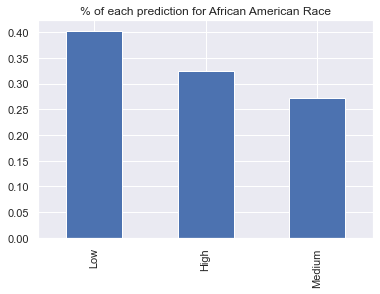

In [61]:
aa.prediction.value_counts(normalize=True).plot(kind = "bar", title = "% of each prediction for African American Race")

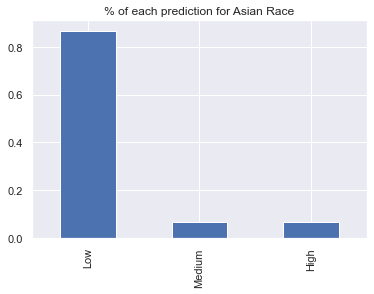

In [62]:
a.prediction.value_counts(normalize= True).plot(kind = "bar", title = "% of each prediction for Asian Race")


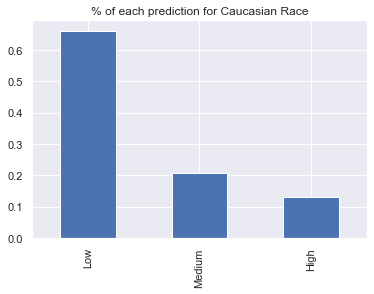

In [63]:
c.prediction.value_counts(normalize= True).plot(kind = "bar", title = "% of each prediction for Caucasian Race")


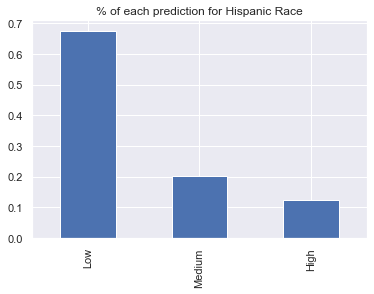

In [64]:
h.prediction.value_counts(normalize= True).plot(kind = "bar", title = "% of each prediction for Hispanic Race")


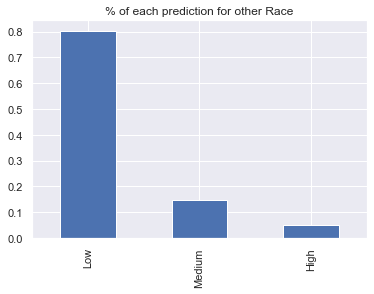

In [65]:
o.prediction.value_counts(normalize= True).plot(kind = "bar", title = "% of each prediction for other Race")

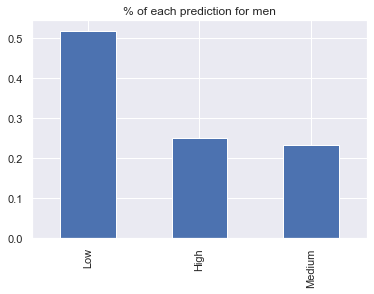

In [66]:
men.prediction.value_counts(normalize= True).plot(kind = "bar", title = "% of each prediction for men")

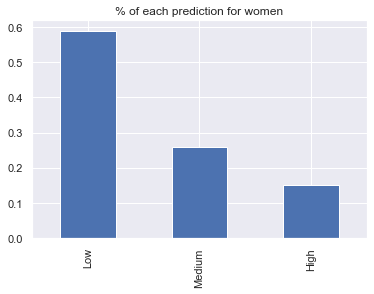

In [67]:
women.prediction.value_counts(normalize= True).plot(kind = "bar", title = "% of each prediction for women")

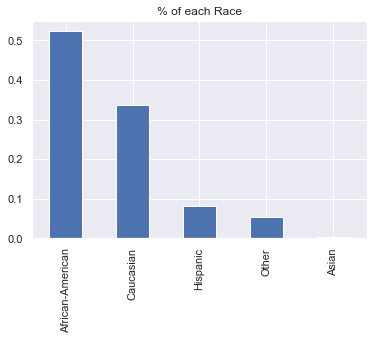

In [68]:
df.race.value_counts(normalize= True).plot(kind = "bar", title = "% of each Race")

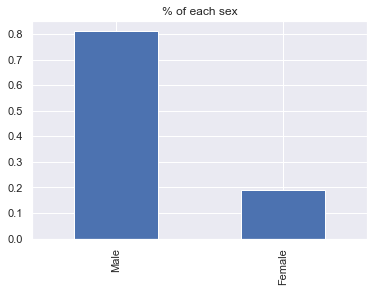

In [69]:
df.sex.value_counts(normalize= True).plot(kind = "bar", title = "% of each sex")

In [70]:

def count_fp_high(df):
    global fp
    fp = 0
    for row in range (len(df)):
        prediction = df.iloc[row][33]
        text_score = df.iloc[row][32]
        if((prediction == "High")and(prediction != text_score)):
            fp = fp + 1
    return fp

def count_fp_medium(df):
    global fp1
    fp1 = 0
    for row in range (len(df)):
        prediction = df.iloc[row][33]
        text_score = df.iloc[row][32]
        if((prediction == "Medium")and(text_score == "Low")):
            fp1 = fp1 + 1
    return fp1





In [95]:
print("the total false positives for 'High' and 'Medium' scores given for African Americans is " + str(count_fp_high(aa) + count_fp_medium(aa)))
print("the total false positives for 'High' and 'Medium' scores given for Caucasians is " + str(count_fp_high(c) + count_fp_medium(c)))
print("the total false positives for 'High' and 'Medium' scores given for Asians is " + str(count_fp_high(a) + count_fp_medium(a)))
print("the total false positives for 'High' and 'Medium' scores given for Hispanics is " + str(count_fp_high(h) + count_fp_medium(h)))
print("the total false positives for 'High' and 'Medium' scores given for Other is " + str(count_fp_high(o) + count_fp_medium(o)))

the total false positives for 'High' and 'Medium' scores given for African Americans is 115
the total false positives for 'High' and 'Medium' scores given for Caucasians is 61
the total false positives for 'High' and 'Medium' scores given for Asians is 0
the total false positives for 'High' and 'Medium' scores given for Hispanics is 13
the total false positives for 'High' and 'Medium' scores given for Other is 4


In [97]:
print("the % of false positive 'High' and 'Medium' predictions of total African American People " + str(100*(count_fp_high(aa) + count_fp_medium(aa)) / len(aa)))
print("the % of false positive 'High' and 'Medium' predictions of total Caucasian People " + str(100*(count_fp_high(c) + count_fp_medium(c)) / len(c)))
print("the % of false positive 'High' and 'Medium' predictions of total Asian People " + str(100*(count_fp_high(a) + count_fp_medium(a)) / len(a)))
print("the % of false positive 'High' and 'Medium' predictions of total Hispanic People " + str(100*(count_fp_high(h) + count_fp_medium(h)) / len(h)))
print("the % of false positive 'High' and 'Medium' predictions of total Other People " + str(100*(count_fp_high(o) + count_fp_medium(o)) / len(o)))


the % of false positive 'High' and 'Medium' predictions of total African American People 9.185303514376997
the % of false positive 'High' and 'Medium' predictions of total Caucasian People 8.165997322623829
the % of false positive 'High' and 'Medium' predictions of total Asian People 0.0
the % of false positive 'High' and 'Medium' predictions of total Hispanic People 6.914893617021277
the % of false positive 'High' and 'Medium' predictions of total Other People 3.278688524590164


In [72]:
aa.text_score.value_counts()

Low       473
High      415
Medium    364
Name: text_score, dtype: int64

In [73]:
aa.prediction.value_counts()

Low       504
High      407
Medium    341
Name: prediction, dtype: int64

In [74]:
c.text_score.value_counts()

Low       471
Medium    188
High       88
Name: text_score, dtype: int64

In [75]:
c.prediction.value_counts()

Low       494
Medium    155
High       98
Name: prediction, dtype: int64

In [76]:
a.text_score.value_counts()

Low       10
Medium     4
High       1
Name: text_score, dtype: int64

In [77]:
a.prediction.value_counts()

Low       13
Medium     1
High       1
Name: prediction, dtype: int64

In [78]:
h.text_score.value_counts()

Low       119
Medium     44
High       25
Name: text_score, dtype: int64

In [79]:
h.prediction.value_counts()

Low       127
Medium     38
High       23
Name: prediction, dtype: int64

In [80]:
o.text_score.value_counts()

Low       97
Medium    19
High       6
Name: text_score, dtype: int64

In [81]:
o.prediction.value_counts()

Low       98
Medium    18
High       6
Name: prediction, dtype: int64

In [86]:
len(o)

122

In [98]:
len(h)

188

In [99]:
len(a)

15

In [100]:
len(c)

747

In [101]:
len(aa)

1252